In [1]:
import cptac
import cptac.utils as ut
import scipy
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy
import math
import pandas as pd

In [2]:
def get_gene_list(dataframe):
    #Returns a list of the genes that are in both proteomics and transcriptomics
    gene_list = []
    prot = dataframe.get_proteomics()
    if isinstance(prot.columns, pd.MultiIndex):
        prot = prot.columns.get_level_values(0)
    trans = dataframe.get_transcriptomics()
    if isinstance(trans.columns, pd.MultiIndex):
        trans = trans.columns.get_level_values(0)
    for i in prot:
        if i in trans and i not in gene_list:
            gene_list.append(i)
    return gene_list

In [3]:
def correlation_list(tissue, gene_list, valid_sample_number = 30, tissue_type = "both"):
    #Returns a list of lists containing the name of the gene and the correlation
    corr_list = []
    pval_list = []
    prot = tissue.get_proteomics(tissue_type)
    if isinstance(prot.columns, pd.MultiIndex):
        prot = ut.reduce_multiindex(df = prot, levels_to_drop="Database_ID")
    
    trans = tissue.get_transcriptomics(tissue_type)
    if isinstance(trans.columns, pd.MultiIndex):
        trans = ut.reduce_multiindex(df = trans, levels_to_drop="Database_ID")
        
    prot_index_values = list(prot.index.values)
    trans_index_values = list(trans.index.values)
    

    for found_index in prot_index_values:
        if found_index not in trans_index_values:
            prot = prot.drop(index=found_index)
    for found_index in trans_index_values:
        if found_index not in prot_index_values:
            trans = trans.drop(index=found_index)
        
    for gene in gene_list:
        prot_measurements = prot[gene]
        prot_count = len(prot_measurements.dropna())
        
        trans_measurements = trans[gene]
        trans_count = len(trans_measurements.dropna())
        
        if prot_count < valid_sample_number or trans_count < valid_sample_number:
            continue
            
        nan_indices = set()
        prot_indices = list(prot_measurements.index.values)
        trans_indices = list(trans_measurements.index.values)
        
        #Here we are only currently taking the first column of multi_indices
        if isinstance(prot_measurements, pd.core.frame.DataFrame): 
            prot_measurements = prot_measurements.iloc[:,0]
        if isinstance(trans_measurements, pd.core.frame.DataFrame):
            trans_measurements = trans_measurements.iloc[:,0]
        for i in range(len(prot_measurements)):
            if math.isnan(prot_measurements[i]):
                nan_indices.add(prot_indices[i])
                
        for i in range(len(trans_measurements)):
            if math.isnan(trans_measurements[i]):
                nan_indices.add(trans_indices[i])
        
        nan_indices = list(nan_indices)
        prot_measurements = prot_measurements.drop(nan_indices)
        trans_measurements = trans_measurements.drop(nan_indices)
        
        correlation,pval = scipy.stats.pearsonr(prot_measurements, trans_measurements)
        if math.isnan(correlation):
            continue
        corr_list.append([gene,correlation])
        pval_list.append([gene, pval])
    return corr_list, pval_list

In [4]:
def ret_list(li):
    #Returns a list of correlations from all genes
    ret_li = []
    for i in li:
        ret_li.append(i[1])   
    return ret_li

# LUAD Gene Correlation Distribution Notebook

The purpose of this notebook is to generate distrubution plots for all the correlations obtained from the genes in the LUAD dataset.

In [5]:
cptac.download("luad")
luad = cptac.Luad()

In [6]:
luad_gene_list = get_gene_list(luad)

Getting correlations from carcinogenic and healthy tissues

In [7]:
luad_corr, luad_pval = correlation_list(luad,luad_gene_list, tissue_type = "tumor")
normal_luad_corr, normal_luad_pval = correlation_list(luad,luad_gene_list,valid_sample_number = 7, tissue_type="normal")

cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (<ipython-input-3-f2fc2988b605>, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (<ipython-input-3-f2fc2988b605>, line 7)


In [8]:
luad_corr_list = (ret_list(luad_corr))
normal_luad_corr_list = (ret_list(normal_luad_corr))

## Plotting

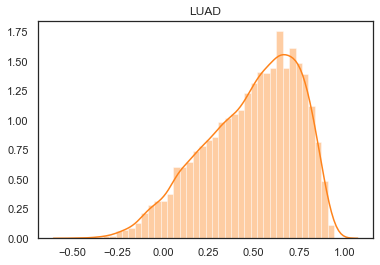

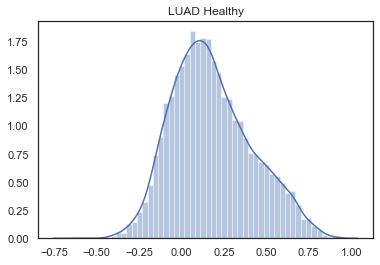

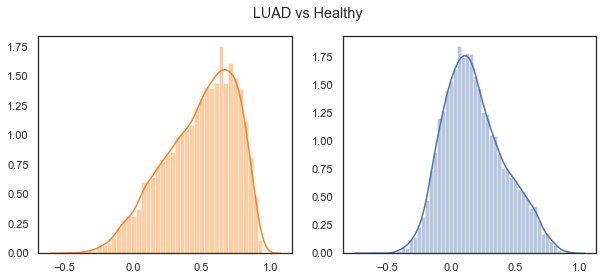

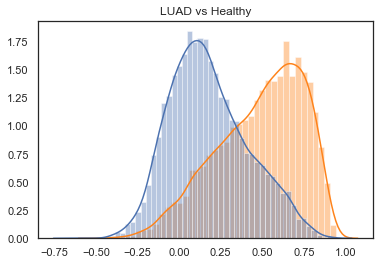

In [9]:
sns.set(style = 'white')
sns.distplot(luad_corr_list, label = "LUAD", color = "#fe831b").set_title('LUAD')
plt.show()
sns.distplot(normal_luad_corr_list, label = "LUAD Healthy", color = "b").set_title('LUAD Healthy')
plt.show()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 4))
fig.suptitle('LUAD vs Healthy')
sns.distplot(luad_corr_list, label = "LUAD", color = "#fe831b",ax = ax1)
sns.distplot(normal_luad_corr_list, label = "LUAD Healthy", color = "b", ax = ax2)
plt.show()
sns.distplot(luad_corr_list, label = "LUAD", color = "#fe831b")
sns.distplot(normal_luad_corr_list, label = "LUAD Normal", color = "b").set_title('LUAD vs Healthy')
plt.show()